## Training Classification and Regression Models

In [1]:
import numpy as np
import datetime as dt
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from yellowbrick.model_selection import RFECV


import warnings
warnings.filterwarnings('ignore')

#### Loading processed dataset

In [2]:
train_df = pd.read_pickle(r'train_feat.pkl')
test_df = pd.read_pickle(r'test_feat.pkl')

In [3]:
# Creating table of Id and log revenue from test data for evaluating models later
test_raw = pd.read_pickle(r'test_df.pkl')
test_raw["totals.transactionRevenue"] = test_raw["totals.transactionRevenue"].astype('float')
test_raw['totals.transactions'].fillna(0, inplace=True)
true_rev = test_raw.groupby('fullVisitorId')[["totals.transactionRevenue"]].sum().apply(np.log1p, axis=1).reset_index()

In [4]:
target = ['fullVisitorId', 'revisit', 'trans_revenue']

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1708337 entries, 0 to 1708336
Data columns (total 38 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   fullVisitorId          object 
 1   networkDomain          int32  
 2   city                   int32  
 3   operatingSystem        int32  
 4   metro                  int32  
 5   region                 int32  
 6   channelGrouping        int32  
 7   referralPath           int32  
 8   country                int32  
 9   source                 int32  
 10  medium                 int32  
 11  keyword                int32  
 12  browser                int32  
 13  deviceCategory         int32  
 14  continent              int32  
 15  subcontinent           int32  
 16  timeOnSite_sum         float64
 17  timeOnSite_min         float64
 18  timeOnSite_max         float64
 19  timeOnSite_mean        float64
 20  pageviews_sum          float64
 21  pageviews_min          float64
 22  pageviews_max     

In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296530 entries, 0 to 296529
Data columns (total 38 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   networkDomain          296530 non-null  int32  
 1   city                   296530 non-null  int32  
 2   operatingSystem        296530 non-null  int32  
 3   metro                  296530 non-null  int32  
 4   region                 296530 non-null  int32  
 5   channelGrouping        296530 non-null  int32  
 6   referralPath           296530 non-null  int32  
 7   country                296530 non-null  int32  
 8   source                 296530 non-null  int32  
 9   medium                 296530 non-null  int32  
 10  keyword                296530 non-null  int32  
 11  browser                296530 non-null  int32  
 12  deviceCategory         296530 non-null  int32  
 13  continent              296530 non-null  int32  
 14  subcontinent           296530 non-nu

## Using Linear Models

#### Logistic Regression

In [36]:
# Seraching best hyperparameter alpha

start = dt.datetime.now()

grid_params = {'alpha':[10 ** x for x in range(-6, 2)]}

clf = SGDClassifier(loss="log", penalty="l2",class_weight='balanced')

gscv_clf = GridSearchCV(clf, grid_params, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

clf_results = gscv_clf.fit(train_df.drop(target, axis=1) , train_df['revisit'])

print("Time taken to run this cell :", dt.datetime.now() - start)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Time taken to run this cell : 0:28:38.128441


In [37]:
print(clf_results.best_params_)
print("Best accuracy is: %.3f" %clf_results.best_score_)

{'alpha': 1e-05}
Best accuracy is: 0.931


#### Linear Regression

In [44]:
# Seraching best hyperparameter alpha
# Training regression only for customers who revisited

start = dt.datetime.now()

grid_params = {'alpha':[10 ** x for x in range(-6, 2)]}

reg = SGDRegressor(loss='squared_loss', penalty='l2')

gscv_reg = GridSearchCV(reg, grid_params, cv=3, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)

gscv_reg.fit(train_df.drop(target, axis=1)[train_df['revisit']==1], train_df['trans_revenue'][train_df['revisit']==1])


print("Time taken to run this cell :", dt.datetime.now() - start)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Time taken to run this cell : 0:00:06.467482


In [45]:
print(gscv_reg.best_params_)
print(" Lowest RMSE is: %.3f" %gscv_reg.best_score_)

{'alpha': 0.0001}
 Lowest RMSE is: -271623806039609824.000


In [47]:
# Using the best hyperparameters to train final model

start = dt.datetime.now()

clf = SGDClassifier(loss="log", alpha=1e-05, penalty="l2", class_weight='balanced')
reg = SGDRegressor(loss='squared_loss', alpha=0.0001, penalty='l2')


clf.fit(train_df.drop(target, axis=1), train_df['revisit'])
reg.fit(train_df.drop(target, axis=1)[train_df['revisit']==1], train_df['trans_revenue'][train_df['revisit']==1])


clf_pred = clf.predict_proba(test_df.drop(target, axis=1))
reg_pred  = reg.predict(test_df.drop(target, axis=1))
     
pred_results = (clf_pred[:, 1] * reg_pred)

print("Time taken to run this cell :", dt.datetime.now() - start)

Time taken to run this cell : 0:02:25.112504


In [49]:
# Create a dataframe of predicted values

pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})
pred_df["PredictedLogRevenue"] = pred_results
pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]

In [50]:
# Calculating final error 

result = pd.merge(pred_df, true_rev , left_on='fullVisitorId', right_on='fullVisitorId')
rms = np.sqrt(mean_squared_error(result['totals.transactionRevenue'], result['PredictedLogRevenue']))
print("The test RMSE is: %.3f" %rms)

The test RMSE is: 15213710318162934.000


Linear model has a very high error.

## Using Ensemble Learning

#### Gradient Boosted Decision Trees

In [13]:
# Hyperparameter dict for classification

grid = {
    'learning_rate': [0.005, 0.01, 0.015],    
    'n_estimators': [40, 100, 200],             
    'num_leaves': [20, 31, 50], 
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],               
    'metric' : ['binary_logloss'],            
    'colsample_bytree' : [0.6, 0.8, 1],     
    'subsample' : [0.7, 0.9, 1],            
    'reg_alpha' : [0,1],                    
    'reg_lambda' : [0,1],                   
    'max_depth': [5, 10, 20],             
    'min_child_samples' : [10, 20, 30] }           

In [14]:
start = dt.datetime.now()

model = lgb.LGBMClassifier()
rscv_clf = RandomizedSearchCV(model, grid, cv=3)
rscv_clf.fit(train_df.drop(target, axis=1) , train_df['revisit'])

print("Time taken to run this cell :", dt.datetime.now() - start)

Time taken to run this cell : 0:06:54.130532


In [15]:
print(rscv_clf.best_params_)
print("Best accuracy is: %.3f" %rscv_clf.best_score_)

{'subsample': 1, 'reg_lambda': 0, 'reg_alpha': 1, 'objective': 'binary', 'num_leaves': 31, 'n_estimators': 200, 'min_child_samples': 20, 'metric': 'binary_logloss', 'max_depth': 10, 'learning_rate': 0.015, 'colsample_bytree': 0.8, 'boosting_type': 'gbdt'}
Best accuracy is: 0.985


In [10]:
# Hyperparameter dict for regression

grid = {
    'learning_rate': [0.005, 0.01, 0.015],   
    'n_estimators': [40, 100, 200],             
    'num_leaves': [20, 30, 50],          
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],          
    'metric' : ['rmse'],                   
    'colsample_bytree' : [0.6, 0.8, 1],    
    'subsample' : [0.7, 0.9, 1],            
    'reg_alpha' : [0, 1],                   
    'reg_lambda' : [0, 1],                  
    'max_depth': [5, 10, 20],           
    'min_child_samples' : [1, 20]              
    }

In [11]:
start = dt.datetime.now()

model = lgb.LGBMRegressor()
rscv_reg = RandomizedSearchCV(model, grid, cv=3)
rscv_reg.fit(train_df.drop(target, axis=1)[train_df['revisit']==1] , train_df['trans_revenue'][train_df['revisit']==1])

print("Time taken to run this cell :", dt.datetime.now() - start)

Time taken to run this cell : 0:00:12.740628


In [12]:
print(rscv_reg.best_params_)
print("Lowest RMSE error is: %.3f" %rscv_reg.best_score_)

{'subsample': 1, 'reg_lambda': 0, 'reg_alpha': 0, 'objective': 'regression', 'num_leaves': 20, 'n_estimators': 200, 'min_child_samples': 20, 'metric': 'rmse', 'max_depth': 20, 'learning_rate': 0.015, 'colsample_bytree': 0.8, 'boosting_type': 'gbdt'}
Lowest RMSE error is: 0.29


In [16]:
# Using the best hyperparameters for the final models

params_clf = {'subsample': 1, 
            'reg_lambda': 0, 
            'reg_alpha': 1, 
            'objective': 'binary', 
            'num_leaves': 31, 
            'n_estimators': 200, 
            'min_child_samples': 20, 
            'metric': 'binary_logloss', 
            'max_depth': 10, 
            'learning_rate': 0.015, 
            'colsample_bytree': 0.8, 
            'boosting_type': 'gbdt'}


params_reg = {'subsample': 1, 
            'reg_lambda': 0, 
            'reg_alpha': 0, 
            'objective': 'regression', 
            'num_leaves': 20, 
            'n_estimators': 200, 
            'min_child_samples': 20, 
            'metric': 'rmse', 
            'max_depth': 20, 
            'learning_rate': 0.015, 
            'colsample_bytree': 0.8, 
            'boosting_type': 'gbdt'}

In [17]:
# Define datasets for classification and regression to be trained in the final model

df_clf = lgb.Dataset(train_df.drop(target, axis=1), label = train_df['revisit'])

df_reg = lgb.Dataset(train_df.drop(target, axis=1)[train_df['revisit']==1], label=train_df['trans_revenue'][train_df['revisit']==1])

In [18]:
# Running lightgbm model for 10 iterations and using its average.
# Source :- https://www.kaggle.com/kostoglot/winning-solution

start = dt.datetime.now()

pred_sum = 0   


for i in range(10):     
    print('Interation number ', i)
    
    # Classifier predicts whether a customer will return in the test window.
    
    clf = lgb.train(params_clf, df_clf)
    pred_clf = clf.predict(test_df.drop(target, axis=1))
   
    
    # Regressor predicts the transaction amount the customers that returned in that duration.
    
    reg = lgb.train(params_reg, df_reg)
    pred_reg = reg.predict(test_df.drop(target, axis=1))
 
    
    # Final prediction is the product of the predictions of the classifier and regressor.
    
    pred_sum += pred_clf * pred_reg


pred_final = pred_sum / 10

print("Time taken to run this cell :", dt.datetime.now() - start)

Interation number  0
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 27663, number of negative: 1680674
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.388079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4469
[LightGBM] [Info] Number of data points in the train set: 1708337, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016193 -> initscore=-4.106854
[LightGBM] [Info] Start training from score -4.106854
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

In [19]:
# # Create a dataframe of predicted values

pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})
pred_df["PredictedLogRevenue"] = pred_final
pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]

In [20]:
# Convert to csv file for kaggle submission

pred_df.to_csv("lgb_models.csv", index=False)

In [23]:
# Calculating final error 

result = pd.merge(pred_df, true_rev , left_on='fullVisitorId', right_on='fullVisitorId') 

In [25]:
from sklearn.metrics import mean_squared_error

rms = np.sqrt(mean_squared_error(result['totals.transactionRevenue'], result['PredictedLogRevenue']))
print("The test RMSE is: %.3f" %rms)

The test RMSE is: 2.103


The ensemble model has much better performance.

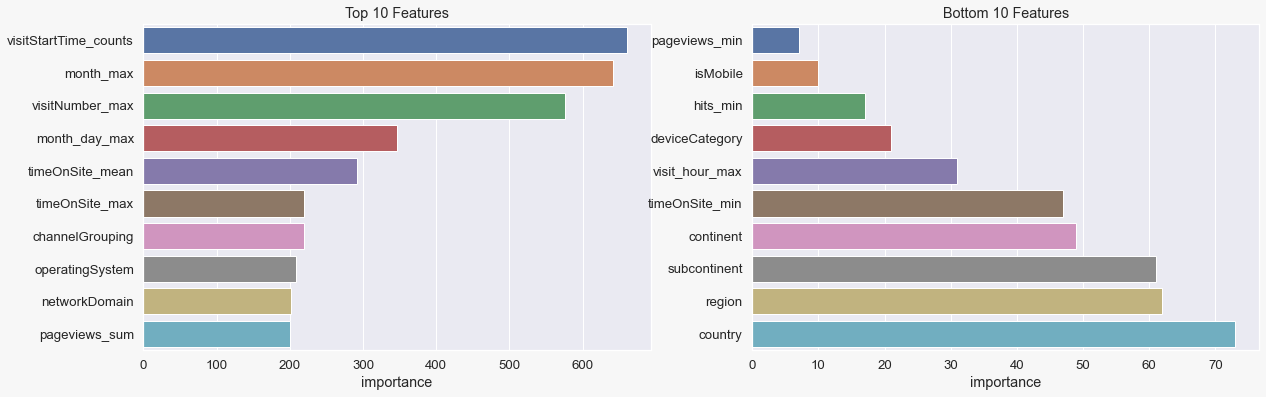

In [32]:
# Plot Feature Importance for Classifier

sns.set_context("poster")
sns.set_style("whitegrid")
sns.set(font_scale=1.2)

feat_imp_df = pd.DataFrame()
feat_imp_df["feature"] = train_df.drop(target, axis=1).columns
feat_imp_df["importance"] = clf.feature_importance()
top_imp_df = feat_imp_df.sort_values(by="importance", ascending=False).head(10)
bot_imp_df = feat_imp_df.sort_values(by="importance", ascending=True).head(10)

fig, ax = plt.subplots(1,2, figsize=(20, 6), facecolor='#f7f7f7')

sns.barplot(x="importance", y="feature", ax=ax[0], data=top_imp_df)
sns.barplot(x="importance", y="feature", ax=ax[1], data=bot_imp_df)

ax[0].set_title('Top 10 Features')
ax[1].set_title('Bottom 10 Features')

for axes in ax:
    axes.set(ylabel=None)

plt.show()

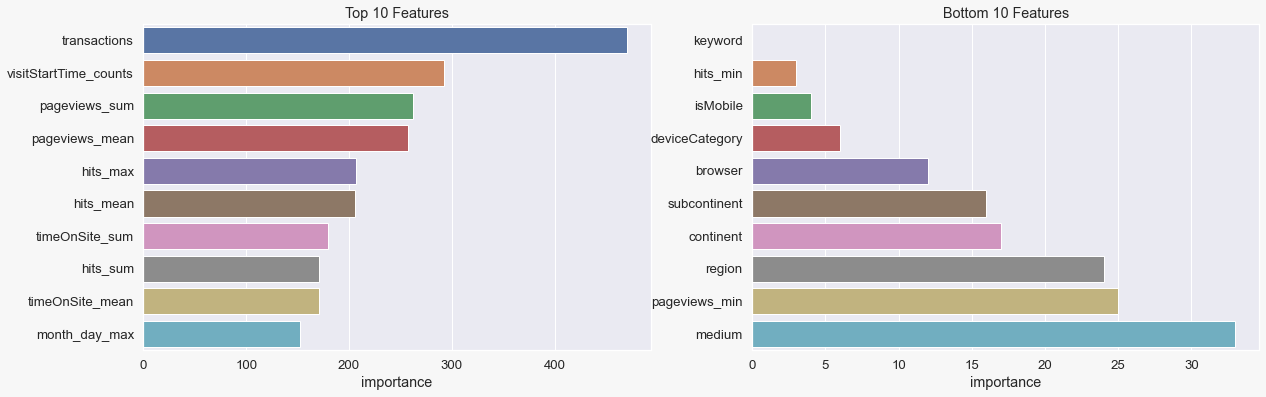

In [33]:
# Plot Feature Importance for Regressor

sns.set_context("poster")
sns.set_style("whitegrid")
sns.set(font_scale=1.2)

feat_imp_df = pd.DataFrame()
feat_imp_df["feature"] = train_df.drop(target, axis=1).columns
feat_imp_df["importance"] = reg.feature_importance()
top_imp_df = feat_imp_df.sort_values(by="importance", ascending=False).head(10)
bot_imp_df = feat_imp_df.sort_values(by="importance", ascending=True).head(10)

fig, ax = plt.subplots(1,2, figsize=(20, 6), facecolor='#f7f7f7')

sns.barplot(x="importance", y="feature", ax=ax[0], data=top_imp_df)
sns.barplot(x="importance", y="feature", ax=ax[1], data=bot_imp_df)

ax[0].set_title('Top 10 Features')
ax[1].set_title('Bottom 10 Features')

for axes in ax:
    axes.set(ylabel=None)

plt.show()

#### Recursive feature elimination

https://towardsdatascience.com/feature-selection-in-python-recursive-feature-elimination-19f1c39b8d15
<br>
https://medium.com/@aneesha/recursive-feature-elimination-with-scikit-learn-3a2cbdf23fb7

The recursive feature elimination method is similar to backward feature selection where a base model is trained on all the features available and rank features based on importance. Models are then trained leaving out the least important features and is run on subsets of remaining features. Finally the set having best accuracy is selected as final features. 

We would explore the possibility of training model using only the best features to acertain improvements in model performance and taining time.



In [5]:
# Using gbdt as our base model

base_model = lgb.LGBMRegressor(objective="regression", metric= "rmse", max_depth=20,
                          num_leaves=20, min_child_samples=20 , learning_rate = 0.015,
                          subsample=1, colsample_bytree=0.8, n_estimators=200, reg_alpha=0, reg_lambda=0, boosting_type="gbdt")

Time taken to run this cell : 0:17:46.348023


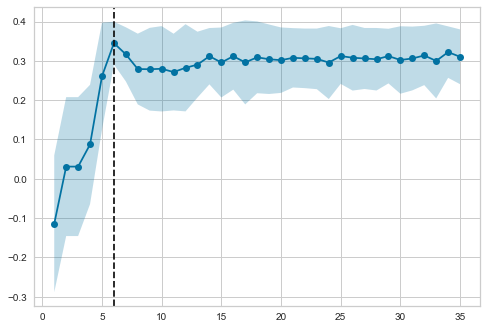

In [7]:
start = dt.datetime.now()

rfecv = RFECV(base_model, step=1) # here step denotes at a time how many features do you want to drop.
rfecv.fit(train_df.drop(target, axis=1)[train_df['revisit']==1], train_df['trans_revenue'][train_df['revisit']==1])

print("Time taken to run this cell :", dt.datetime.now() - start)

In [8]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 6


In [9]:
# The mask of selected features.
rfecv.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
        True,  True, False, False, False, False, False,  True,  True,
       False, False, False,  True, False, False, False, False])

In [11]:
train_df_copy = train_df.drop(target, axis=1)

train_df_copy.drop(train_df_copy.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

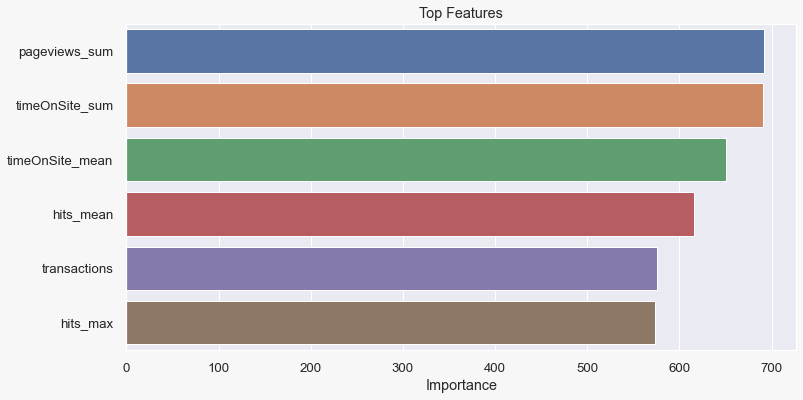

In [16]:
# Plotting selected features

sns.set_context("poster")
sns.set_style("whitegrid")
sns.set(font_scale=1.2)

feat_df = pd.DataFrame()
feat_df["feature"] = train_df_copy.columns
feat_df["importance"] = rfecv.estimator_.feature_importances_
top_imp_df = feat_df.sort_values(by="importance", ascending=False)


plt.figure(figsize=(12, 6), facecolor='#f7f7f7')

sns.barplot(x="importance", y="feature", data=top_imp_df)

plt.title('Top Features')
plt.xlabel('Importance')
plt.ylabel(None)
plt.show()


In [17]:
train_df_copy.columns

Index(['timeOnSite_sum', 'timeOnSite_mean', 'pageviews_sum', 'hits_max',
       'hits_mean', 'transactions'],
      dtype='object')

In [18]:
imp_features  = ['timeOnSite_sum', 'timeOnSite_mean', 'pageviews_sum', 'hits_max',
                'hits_mean', 'transactions']

final_features = imp_features + target

In [19]:
# Using only selected features for training

train_df_feat = train_df[final_features]
test_df_feat  = test_df[final_features]

Repeating the same training process performed earlier but with a dataset of smaller dimension.

#### GBDT Classifier

In [30]:
grid = {
    'learning_rate': [0.005, 0.01, 0.015],    
    'n_estimators': [40, 100, 200],             
    'num_leaves': [20, 31, 50], 
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],               
    'metric' : ['binary_logloss'],            
    'colsample_bytree' : [0.6, 0.8, 1],     
    'subsample' : [0.7, 0.9, 1],            
    'reg_alpha' : [0,1],                    
    'reg_lambda' : [0,1],                   
    'max_depth': [5, 10, 20],             
    'min_child_samples' : [10, 20, 30] }           

In [31]:
start = dt.datetime.now()

model = lgb.LGBMClassifier()
rscv_clf = RandomizedSearchCV(model, grid, cv=3)
rscv_clf.fit(train_df_feat.drop(target, axis=1) , train_df_feat['revisit'])

print("Time taken to run this cell :", dt.datetime.now() - start)

Time taken to run this cell : 0:03:33.059739


In [32]:
print(rscv_clf.best_params_)
print("Best accuracy is: %.3f" %rscv_clf.best_score_)

{'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 1, 'objective': 'binary', 'num_leaves': 50, 'n_estimators': 200, 'min_child_samples': 30, 'metric': 'binary_logloss', 'max_depth': 5, 'learning_rate': 0.015, 'colsample_bytree': 0.8, 'boosting_type': 'gbdt'}
Best accuracy is: 0.985


#### GBDT Regressor

In [27]:
grid = {
    'learning_rate': [0.005, 0.01, 0.015],   
    'n_estimators': [40, 100, 200],             
    'num_leaves': [20, 30, 50],          
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],          
    'metric' : ['rmse'],                   
    'colsample_bytree' : [0.6, 0.8, 1],    
    'subsample' : [0.7, 0.9, 1],            
    'reg_alpha' : [0, 1],                   
    'reg_lambda' : [0, 1],                  
    'max_depth': [5, 10, 20],           
    'min_child_samples' : [1, 20]              
    }

In [28]:
start = dt.datetime.now()

model = lgb.LGBMRegressor()
rscv_reg = RandomizedSearchCV(model, grid, cv=3)
rscv_reg.fit(train_df_feat.drop(target, axis=1)[train_df_feat['revisit']==1] , train_df_feat['trans_revenue'][train_df_feat['revisit']==1])

print("Time taken to run this cell :", dt.datetime.now() - start)

Time taken to run this cell : 0:00:04.399195


In [29]:
print(rscv_reg.best_params_)
print("Lowest RMSE error is: %.3f" %rscv_reg.best_score_)

{'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0, 'objective': 'regression', 'num_leaves': 20, 'n_estimators': 200, 'min_child_samples': 20, 'metric': 'rmse', 'max_depth': 10, 'learning_rate': 0.015, 'colsample_bytree': 0.6, 'boosting_type': 'gbdt'}
Lowest RMSE error is: 0.307


#### Final training using best hyperparameters

In [33]:

params_clf = {'subsample': 0.9, 
            'reg_lambda': 1, 
            'reg_alpha': 1, 
            'objective': 'binary', 
            'num_leaves': 50, 
            'n_estimators': 200, 
            'min_child_samples': 30, 
            'metric': 'binary_logloss', 
            'max_depth': 5, 
            'learning_rate': 0.015, 
            'colsample_bytree': 0.8, 
            'boosting_type': 'gbdt'}


params_reg = {'subsample': 1, 
            'reg_lambda': 1, 
            'reg_alpha': 0, 
            'objective': 'regression', 
            'num_leaves': 20, 
            'n_estimators': 200, 
            'min_child_samples': 20, 
            'metric': 'rmse', 
            'max_depth': 10, 
            'learning_rate': 0.015, 
            'colsample_bytree': 0.6, 
            'boosting_type': 'gbdt'}

In [34]:
df_clf = lgb.Dataset(train_df_feat.drop(target, axis=1), label = train_df_feat['revisit'])

df_reg = lgb.Dataset(train_df_feat.drop(target, axis=1)[train_df_feat['revisit']==1], label=train_df_feat['trans_revenue'][train_df_feat['revisit']==1])

In [36]:
# Using average predictions of 10 iterations for final evaluation

start = dt.datetime.now()

pred_sum = 0   


for i in range(10):     
    print('Interation number ', i)
        
    clf = lgb.train(params_clf, df_clf)
    pred_clf = clf.predict(test_df_feat.drop(target, axis=1))
     
    reg = lgb.train(params_reg, df_reg)
    pred_reg = reg.predict(test_df_feat.drop(target, axis=1))
 
    pred_sum += pred_clf * pred_reg

pred_final = pred_sum / 10

print("Time taken to run this cell :", dt.datetime.now() - start)

Interation number  0
[LightGBM] [Info] Number of positive: 27663, number of negative: 1680674
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1229
[LightGBM] [Info] Number of data points in the train set: 1708337, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016193 -> initscore=-4.106854
[LightGBM] [Info] Start training from score -4.106854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [37]:
pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})
pred_df["PredictedLogRevenue"] = pred_final
pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]

In [20]:
pred_df.to_csv("lgb_feat.csv", index=False)

In [39]:
result = pd.merge(pred_df, true_rev , left_on='fullVisitorId', right_on='fullVisitorId') 

In [40]:
rms = np.sqrt(mean_squared_error(result['totals.transactionRevenue'], result['PredictedLogRevenue']))
print("The test RMSE is: %.3f" %rms)

The test RMSE is: 2.095


The feature selection has resulted in a model with lower error